In [125]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
import matplotlib.pyplot as plt


## Define constans and functions

In [126]:
locations = ["A", "B", "C"]
features_order = []
A_B_ratio = 6.73
A_C_ratio = 8.17

LAGGED_COLUMNS_TO_KEEP = [
    'direct_rad:W_lag_1h', 
    'direct_rad:W_lag_forward_1h', 
    'clear_sky_rad:W_lag_1h', 
    'clear_sky_rad:W_lag_forward_1h', 
    'diffuse_rad:W_lag_1h', 
    'diffuse_rad:W_lag_forward_1h', 
    'direct_rad_1h:J_lag_1h', 
    'direct_rad_1h:J_lag_forward_1h', 
    'is_in_shadow:idx_lag_1h', 
    'is_in_shadow:idx_lag_forward_1h', 
    'clear_sky_energy_1h:J_lag_1h', 
    'clear_sky_energy_1h:J_lag_forward_1h', 
    'effective_cloud_cover:p_lag_1h', 
    'effective_cloud_cover:p_lag_forward_1h', 
    'visibility:m_lag_1h', 
    'visibility:m_lag_forward_1h', 
    'total_cloud_cover:p_lag_1h', 
    'total_cloud_cover:p_lag_forward_1h', 


    # 'direct_rad:W_lag_2h', 
    # 'direct_rad:W_lag_forward_2h', 
    # 'clear_sky_rad:W_lag_2h', 
    # 'clear_sky_rad:W_lag_forward_2h', 
    # 'diffuse_rad:W_lag_2h', 
    # 'diffuse_rad:W_lag_forward_2h', 
    # 'direct_rad_1h:J_lag_2h', 
    # 'direct_rad_1h:J_lag_forward_2h', 
    # 'is_in_shadow:idx_lag_2h', 
    # 'is_in_shadow:idx_lag_forward_2h', 
    # 'clear_sky_energy_1h:J_lag_2h', 
    # 'clear_sky_energy_1h:J_lag_forward_2h', 
    # 'effective_cloud_cover:p_lag_2h', 
    # 'effective_cloud_cover:p_lag_forward_2h', 
    # 'visibility:m_lag_2h', 
    # 'visibility:m_lag_forward_2h', 
    # 'total_cloud_cover:p_lag_2h', 
    # 'total_cloud_cover:p_lag_forward_2h', 

    # 'direct_rad:W_lag_3h', 
    # 'direct_rad:W_lag_forward_3h', 
    # 'clear_sky_rad:W_lag_3h', 
    # 'clear_sky_rad:W_lag_forward_3h', 
    # 'diffuse_rad:W_lag_3h', 
    # 'diffuse_rad:W_lag_forward_3h', 
    # 'direct_rad_1h:J_lag_3h', 
    # 'direct_rad_1h:J_lag_forward_3h', 
    # 'is_in_shadow:idx_lag_3h', 
    # 'is_in_shadow:idx_lag_forward_3h', 
    # 'clear_sky_energy_1h:J_lag_3h', 
    # 'clear_sky_energy_1h:J_lag_forward_3h', 
    # 'effective_cloud_cover:p_lag_3h', 
    # 'effective_cloud_cover:p_lag_forward_3h', 
    # 'visibility:m_lag_3h', 
    # 'visibility:m_lag_forward_3h', 
    # 'total_cloud_cover:p_lag_3h', 
    # 'total_cloud_cover:p_lag_forward_3h'
]

CUSTOM_COLUMNS_TO_KEEP = [
    "hour_cos",
    "hour_sin",
    "month_sin",
    "month_cos",
    "hours_since_forecast",
]

WEATHER_FEATURES = [
    "direct_rad:W",
    "clear_sky_rad:W",
    "diffuse_rad:W",
    "direct_rad_1h:J",
    "is_in_shadow:idx",
    "clear_sky_energy_1h:J",
    "effective_cloud_cover:p",
    "visibility:m",
    "total_cloud_cover:p",
]


TEST_COLUMNS_TO_KEEP = [
    "direct_rad:W",
    "clear_sky_rad:W",
    "diffuse_rad:W",
    "direct_rad_1h:J",
    "is_in_shadow:idx",
    "clear_sky_energy_1h:J",
    "diffuse_rad_1h:J",
    "is_day:idx",
    "sun_elevation:d",
    "ceiling_height_agl:m",
    "effective_cloud_cover:p",
    # "visibility:m",
    "total_cloud_cover:p",
    "air_density_2m:kgm3",
    "wind_speed_v_10m:ms",
    "dew_point_2m:K",
    "wind_speed_u_10m:ms",
    "t_1000hPa:K",
    "absolute_humidity_2m:gm3",
    "snow_water:kgm2",
    "relative_humidity_1000hPa:p",
    "fresh_snow_24h:cm",
    "cloud_base_agl:m",
    "fresh_snow_12h:cm",
    "snow_depth:cm",
    "dew_or_rime:idx",
    "fresh_snow_6h:cm",
    "super_cooled_liquid_water:kgm2",
    "fresh_snow_3h:cm",
    "rain_water:kgm2",
    "precip_type_5min:idx",
    "precip_5min:mm",
    "fresh_snow_1h:cm",
    "sun_azimuth:d",
    "msl_pressure:hPa",
    "pressure_100m:hPa",
    "pressure_50m:hPa",
    "sfc_pressure:hPa",
    "prob_rime:p",
    "wind_speed_10m:ms",
    # "elevation:m",
    # "snow_density:kgm3",
    # "snow_drift:idx",
    "snow_melt_10min:mm",
    "wind_speed_w_1000hPa:ms",
    "observed_or_estimated",
    # "location_A",
    # "location_B",
    # "location_C",
    # "date_calc",
] + CUSTOM_COLUMNS_TO_KEEP  +  LAGGED_COLUMNS_TO_KEEP

COLUMNS_TO_KEEP = TEST_COLUMNS_TO_KEEP + ["pv_measurement"]



def create_weather_lagged_features(df, weather_features):
    # Choose the weather features for which you want to create lagged versions
    for feature in weather_features:
        # Assuming hourly data, adjust the lags for your specific dataset
        # Creating lagged features for 1 hour, 1 day, and 1 week
        df[f'{feature}_lag_1h'] = df[feature].shift(1)
        # df[f'{feature}_lag_2h'] = df[feature].shift(2)
        # df[f'{feature}_lag_3h'] = df[feature].shift(3)

        df[f'{feature}_lag_forward_1h'] = df[feature].shift(-1)
        # df[f'{feature}_lag_forward_2h'] = df[feature].shift(-2)
        # df[f'{feature}_lag_forward_3h'] = df[feature].shift(-3)
        # df[f'{feature}_lag_24h'] = df[feature].shift(24*4)
        # df[f'{feature}_lag_168h'] = df[feature].shift(24 * 7 * 4 * 365)
        # df[f'{feature}_front_lag_1h'] = df[feature].shift(-4)
        # df[f'{feature}_front_lag_24h'] = df[feature].shift(-24*4)


    # Handling edges by filling NaNs with appropriate values or dropping them
    # You may choose to fill with zeroes or interpolate, based on what makes more sense for your data
    df.fillna(method='ffill', inplace=True)  # Forward fill
    df.fillna(method='bfill', inplace=True)  # Backward fill
    
    return df


def create_lagged_features(df, column_name='pv_measurement'):
    # Assuming 'date_forecast' is the datetime column used for sorting

    df[f'{column_name}_prev_month'] = df[column_name].shift(24*7) # previous week

    # For yearly lag, you would need to calculate the number of observations per year
    # If the data is not consistent (leap years, etc.), you may need a more complex method
    # Here's a simple version assuming 365 days a year:
    df[f'{column_name}_prev_year'] = df[column_name].shift(24*365) # previous year
    df[f'{column_name}_2years_ago'] = df[column_name].shift(24*365*2) # next year

    # Handling edges by filling NaNs with appropriate values or dropping them
    df.fillna(method='ffill', inplace=True)  # Forward fill
    df.fillna(method='bfill', inplace=True)  # Backward fill

    return df


## Prepare data


In [133]:
def add_custom_fields(df):
    df['hour_sin'] = np.sin(2 * np.pi * df['date_forecast'].dt.hour / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['date_forecast'].dt.hour / 24)

    df['month_sin'] = np.sin(2 * np.pi * df['date_forecast'].dt.month / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['date_forecast'].dt.month / 12)
    df['day-of-year'] = df['date_forecast'].dt.dayofyear
   
    return df

def add_calc_date(df_observed, df_estimated, df_test):
    # Function to calculate the difference in hours
    def calculate_hour_difference(row):
        diff = row['date_calc'] - row['date_forecast']
        return diff.total_seconds() / 3600  # Convert difference to hours

    # Apply the function to calculate the hour difference for df_estimated and df_test
    df_estimated['hours_since_forecast'] = df_estimated.apply(calculate_hour_difference, axis=1)
    df_test['hours_since_forecast'] = df_test.apply(calculate_hour_difference, axis=1)

    # Fill in zero for df_observed
    df_observed['hours_since_forecast'] = 0

    return df_observed, df_estimated, df_test


def remove_outliers(df):
    # Use a mask to filter out the rows where rolling std is zero but keep the rows where the value itself is zero
    mask = (df['pv_measurement'].rolling(5).std() == 0) & (df['pv_measurement'] != 0)
    df = df[~mask]
    return df

def resample_add_data(df, is_test_data):
    df = add_custom_fields(df)
    df.set_index('date_forecast', inplace=True)
    df = df.resample('1H').mean()
    
    # Remove empty dates if test data
    if is_test_data:
        non_nan_threshold = len(df.columns) // 2  
        df.dropna(thresh=non_nan_threshold, inplace=True)
    df.interpolate(method="linear", inplace=True)
    
    return df

def add_location_feature(X, location):
      # Treat location as a categorical feature by converting it to a category type
    
    bins = [-90, 0, 45, 90]
    labels = ['Low', 'Medium', 'High']
    X['sun_elevation:d'] = pd.cut(X['sun_elevation:d'], bins=bins, labels=labels, include_lowest=True)
    X['location'] = location
    X['location'] = X['location'].astype(str)  # Convert to string if 'location' is not an int
    X['dew_or_rime:idx'] = X['dew_or_rime:idx'].astype(str)
    X['is_day:idx'] = X['is_day:idx'].astype(str)
    X['is_in_shadow:idx'] = X['is_in_shadow:idx'].astype(str)
    categorical_columns = ['location', 'dew_or_rime:idx', 'is_day:idx', 'is_in_shadow:idx', 'sun_elevation:d']

    # Before filling NaN values, add 'missing' as a category for each categorical column.
    for column in categorical_columns:
        X[column] = X[column].astype('category')  # Ensure the column is of type 'category'.
        if 'missing' not in X[column].cat.categories:
            X[column] = X[column].cat.add_categories(['missing'])  # Add 'missing' as a new category.
        X[column] = X[column].fillna('missing')
    X['location'] = X['location'].astype('category')
    X['dew_or_rime:idx'] = X['dew_or_rime:idx'].astype('category')
    X['is_day:idx'] = X['is_day:idx'].astype('category')
    X['is_in_shadow:idx'] = X['is_in_shadow:idx'].astype('category')
    X['sun_elevation:d'] = X['sun_elevation:d'].astype('category')
    
    return X

def add_scaling(X_test, X_training, location):
    global scalers
    continuous_columns = X_training.select_dtypes(include=['float32', 'int32']).columns
    if location not in scalers:
        scalers[location] = MinMaxScaler()
    X_training[continuous_columns] = scalers[location].fit_transform(X_training[continuous_columns])
    
    X_test[continuous_columns] = scalers[location].transform(X_test[continuous_columns])

    return X_test, X_training

def make_observed_and_estimated_category(df_observed, df_estimated, df_test):
     # Hot encode in wether observed or estimated
    df_observed['observed_or_estimated'] = 'observed'
    df_estimated['observed_or_estimated'] = 'estimated'
    df_test['observed_or_estimated'] = 'estimated'
    # Concatenate observed and estimated
    df_training = pd.concat([df_observed, df_estimated], axis=0).sort_values(by="date_forecast")
    df_training['observed_or_estimated'] = df_training['observed_or_estimated'].astype('category')
    df_test['observed_or_estimated'] = df_test['observed_or_estimated'].astype('category')

    return df_training, df_test

def analyze_pv_measurements(dataframe):
    # Filter the DataFrame for rows where 'is_day' is 0
    night_data = dataframe[dataframe['is_day:idx'] == 0]

    # Analysis of 'pv_measurements' during night time
    pv_stats = night_data['pv_measurement'].describe()

    return pv_stats

    
    

In [136]:

# Initialize a dictionary to hold the scalers for each location

scalers = {}
scaling_target = False

def prepare_data(location):
    # Load data

    scaling = True  # Set scaling to True to enable individual scaling for each location
    global scalers
    global scaling_target
    # Load training data
    df_observed = pd.read_parquet(f"data/{location}/X_train_observed.parquet")
    df_estimated = pd.read_parquet(f"data/{location}/X_train_estimated.parquet")
    df_target = pd.read_parquet(f"data/{location}/train_targets.parquet")


    # Load test data
    df_test = pd.read_parquet(f"data/{location}/X_test_estimated.parquet")

    # Add calculated date
    df_observed, df_estimated, df_test = add_calc_date(df_observed, df_estimated, df_test)
    # Hot encode in wether observed or estimated

    # Resample and add custom fields

    df_observed = resample_add_data(df_observed, False)
    df_estimated = resample_add_data(df_estimated, False)
    df_test = resample_add_data(df_test, True)

    df_training, df_test = make_observed_and_estimated_category(df_observed, df_estimated, df_test)

    # Merge training with target data
    df_training = pd.merge(df_training, df_target, left_on="date_forecast", right_on="time", how="inner")
    
    # Create lagged features and remove outliers training
    df_training = create_weather_lagged_features(df_training, WEATHER_FEATURES)
    df_training = df_training[COLUMNS_TO_KEEP]
    df_training = remove_outliers(df_training)

    # Create lagged features test
    df_test = create_weather_lagged_features(df_test, WEATHER_FEATURES)
    df_test = df_test[TEST_COLUMNS_TO_KEEP]

    print(analyze_pv_measurements(df_training))
    # Make training x and y
    y_training = df_training["pv_measurement"]
    X_training = df_training.drop("pv_measurement", axis=1)

    # Add categories
    X_training = add_location_feature(X_training, location)
    X_test = add_location_feature(df_test, location)
    
    # Add scaling
    if scaling:
        X_test, X_training = add_scaling(X_test, X_training, location)
    X_test.reset_index(inplace=True)
    X_test.drop("date_forecast", axis=1, inplace=True)
    # y_training = np.log1p(y_training)
    if scaling_target:
        if location == "B": 
            y_training = A_B_ratio*(y_training)
        if location == "C":
            y_training = A_C_ratio*(y_training)
    return X_training, X_test, y_training



# Use prepare_data function

combined_X_train = pd.DataFrame()
combined_X_val = pd.DataFrame()
combined_Y_train = pd.DataFrame()
combined_Y_val = pd.DataFrame()
combined_X_test = pd.DataFrame()

# For validation locally 
for location in locations:
    # Prepare the training data
    X_training, X_test, y_training = prepare_data(location)
    
    # Split and concatenate the training data
    X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.0001, random_state=42)
    combined_X_train = pd.concat([combined_X_train, X_train])
    combined_X_val = pd.concat([combined_X_val, X_val])
    combined_Y_train = pd.concat([combined_Y_train, y_train])
    combined_Y_val = pd.concat([combined_Y_val, y_val])
    combined_X_test = pd.concat([combined_X_test, X_test])

    # Spl

combined_X_test
combined_X_train, combined_Y_train = shuffle(combined_X_train, combined_Y_train, random_state=42)
combined_X_val, combined_Y_val = shuffle(combined_X_val, combined_Y_val, random_state=42)

for location in locations: 
    prepare_data(location)

count    15976.000000
mean         0.146713
std          3.232574
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        206.580000
Name: pv_measurement, dtype: float64
count    14821.000000
mean         0.257302
std          6.118606
min         -0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        273.412500
Name: pv_measurement, dtype: float64
count    13238.000000
mean         0.088243
std          2.489824
min         -0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        137.200000
Name: pv_measurement, dtype: float64
count    15976.000000
mean         0.146713
std          3.232574
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        206.580000
Name: pv_measurement, dtype: float64
count    14821.000000
mean         0.257302
std          6.118606
min         -0.000000
25%          0.000000
50%          0.000000
75%          0.0

## Train

In [123]:
def train_model(X_train, y_train, X_val, y_val, location):
    cat_features = [index for index, col in enumerate(X_train.columns) if col in ['location', 'dew_or_rime:idx', 'is_day:idx', 'is_in_shadow:idx', 'observed_or_estimated', 'sun_elevation:d']]
    
    model = CatBoostRegressor(
        iterations=6000,
        learning_rate=0.007,
        depth=12,  # assuming you decided to keep the depth reduced
        loss_function='MAE',
        verbose=200,
        cat_features=cat_features,
    )

    # Use the provided validation set for early stopping
    
    model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=False)
    model.save_model(f"catboost_model_merged.cbm")

def evaluate_model(X_val, y_val, location):
    global scaling_target  
    model = CatBoostRegressor()
    model.load_model(f"catboost_model_merged.cbm")
    
    # Unique locations in the X_val dataframe
    locations = X_val['location'].unique()
    
    for location in locations:
        # Filter X_val and y_val for the current location
        X_val_loc = X_val[X_val['location'] == location]
        y_val_loc = y_val[X_val['location'] == location]
        
        # Make predictions
        y_pred_loc = model.predict(X_val_loc)
        
        # Apply the transformation if needed (assuming y_val_loc and y_pred_loc are log1p transformed)
        # y_val_loc = np.expm1(y_val_loc)
        # y_pred_loc = np.expm1(y_pred_loc)
        
        # Calculate MAE for the current location
        mae = mean_absolute_error(y_val_loc, y_pred_loc)

        if scaling_target: 
            if location == "B": 
                mae = mae/A_B_ratio
            if location == "C":
                mae = mae/A_C_ratio
                
        print(f'Location {location}, Mean Absolute Error: {mae}')


# Train the model using all available training data and the initial validation set for early stopping
train_model(combined_X_train, combined_Y_train, combined_X_val, combined_Y_val, location)
# Evaluate the model using the same validation set
evaluate_model(combined_X_val, combined_Y_val, location)


0:	learn: 290.1953064	test: 746.0199260	best: 746.0199260 (0)	total: 159ms	remaining: 15m 55s
200:	learn: 120.8484252	test: 331.9994891	best: 331.9994891 (200)	total: 18s	remaining: 8m 40s
400:	learn: 88.5187966	test: 247.5833177	best: 247.5833177 (400)	total: 36.4s	remaining: 8m 27s
600:	learn: 78.5335184	test: 223.3985939	best: 223.1424946 (595)	total: 54s	remaining: 8m 5s
800:	learn: 74.1823240	test: 217.0706197	best: 216.8759199 (793)	total: 1m 12s	remaining: 7m 47s
1000:	learn: 71.4073847	test: 217.0797875	best: 216.3070992 (810)	total: 1m 29s	remaining: 7m 26s
1200:	learn: 70.2968380	test: 217.4132006	best: 216.3070992 (810)	total: 1m 46s	remaining: 7m 5s
1400:	learn: 69.3175261	test: 215.9244829	best: 215.9236134 (1398)	total: 2m 3s	remaining: 6m 45s
1600:	learn: 67.9065367	test: 215.8073136	best: 215.7751854 (1593)	total: 2m 21s	remaining: 6m 27s
1800:	learn: 65.7463191	test: 215.5866575	best: 215.2934390 (1751)	total: 2m 39s	remaining: 6m 11s
2000:	learn: 63.4782048	test: 212.

## Print feature importance

In [139]:
def feature_importance():
    model = CatBoostRegressor()
    model.load_model(f"catboost_model_merged.cbm")

    # Getting feature importances
    feature_importances = model.get_feature_importance()
    feature_names = model.feature_names_

    # Creating a DataFrame from feature importances
    df_feature_importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })

    # Sorting the DataFrame by importance in descending order
    df_feature_importances = df_feature_importances.sort_values(by='Importance', ascending=False)

    return df_feature_importances


feature_importances = feature_importance()
# Calling the function
print(feature_importances.tail(25))

                            Feature  Importance
63       total_cloud_cover:p_lag_1h    0.582256
7                        is_day:idx    0.496530
29             precip_type_5min:idx    0.483350
51             diffuse_rad:W_lag_1h    0.440077
8                   sun_elevation:d    0.380872
26   super_cooled_liquid_water:kgm2    0.378381
6                  diffuse_rad_1h:J    0.367393
18                  snow_water:kgm2    0.329063
20                fresh_snow_24h:cm    0.240577
46             hours_since_forecast    0.228312
41            observed_or_estimated    0.220307
56  is_in_shadow:idx_lag_forward_1h    0.182894
30                   precip_5min:mm    0.169405
40          wind_speed_w_1000hPa:ms    0.128355
4                  is_in_shadow:idx    0.081028
22                fresh_snow_12h:cm    0.067053
23                    snow_depth:cm    0.049861
28                  rain_water:kgm2    0.028032
55          is_in_shadow:idx_lag_1h    0.013869
24                  dew_or_rime:idx    0

## Make predictions

In [74]:

# Assuming you have defined WEATHER_FEATURES, TEST_COLUMNS_TO_KEEP, and other functions previously

def make_predictions(df_test_pred):
    model = CatBoostRegressor()
    model.load_model(f"catboost_model_merged.cbm")
    # Load model 
    model = CatBoostRegressor()
    model.load_model(f"catboost_model_merged.cbm")
    
    preds = model.predict(df_test_pred)
    
    # Inverse transform the predictions
    # preds = np.expm1(preds)
    return preds





## Evaluate locally


[ 2.47740967e-03 -7.32434446e-02  4.24402240e+03  2.43433235e+03]


ValueError: x and y must have same first dimension, but have shapes (4,) and (200,)

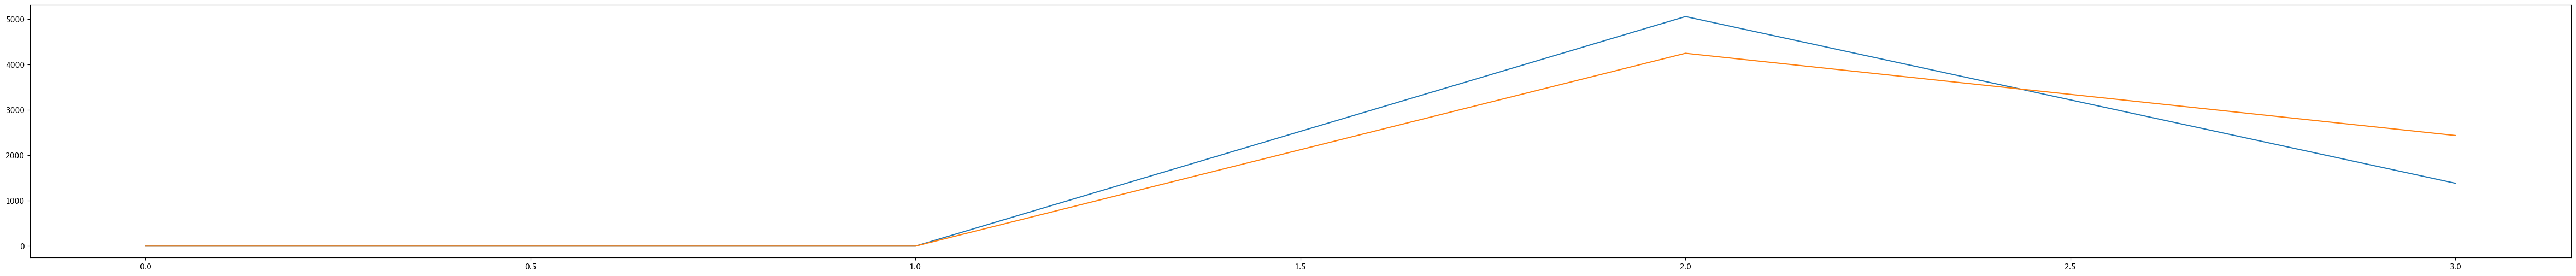

In [36]:
import matplotlib.pyplot as plt



def evaluate_model_locally(location, X_val_loc, y_val_loc):
    # Load the test data
    global scaling_target
    
    # Make predictions
    preds = make_predictions(X_val_loc)[-200:]
    target = y_val_loc.values[-200:]
    if scaling_target:
        if location == "B": 
            preds = (preds)/A_B_ratio
        
        if location == "C":
            preds = (preds)/A_C_ratio

    # differences = preds - target

    # # Count predictions lower than the actual
    # lower_predictions = (differences < 0) & (target != 0)
    # # Count predictions higher than the actual
    # higher_predictions = (differences > 0) & (target != 0)

    # # Biggest misreads
    # absolute_differences = abs(differences)
    # max_diff_index = absolute_differences.argmax()  # Index of the biggest difference
    # max_diff_value = absolute_differences[max_diff_index]  # Value of the biggest difference
    # print(f"Number of predictions that are a lower value than the actual, given that the actual is not 0: {lower_predictions.sum()}")
    # print(f"Number of predictions that are larger than the target, given that the target is not 0: {higher_predictions.sum()}")
    # print(f"The biggest misread is at index {max_diff_index} with a difference of {max_diff_value}")

    # write preds to a csv file
    # df = pd.DataFrame(preds)
    # df.to_csv(f"best_preds_{location}.csv")
    # make array of indices of numpy array target 

    # plot the preds from the csv file "best_preds_{location}.csv"
    df = pd.read_csv(f"best_preds_{location}.csv")[-200:]
    # df.reset_index(inplace=True)
    best_preds = df["0"]
    print(preds)
    index = np.arange(len(target))
    # Plotting
    plt.figure(figsize=(60,6))
    plt.plot(index, target, label="Target")
    plt.plot(index, preds, label="Predictions")
    plt.plot(index, best_preds.values, label="Best predictions")

    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Target vs Predictions')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()

for location in locations:
    X_val_loc = combined_X_val[combined_X_val['location'] == location].sort_index()
    y_val_loc = combined_Y_val[combined_X_val['location'] == location].sort_index()
    evaluate_model_locally(location, X_val_loc, y_val_loc)


## Submit to csv 1

In [124]:
df_submission = pd.read_csv("data/test.csv")

preds = make_predictions(combined_X_test)
print(len(preds))
print(len(df_submission))
df_submission["prediction"] = preds

# Save the results to a new submission file
df_submission[["id", "prediction"]].to_csv("kaggle_submission_catboost_16.csv", index=False)

2160
2160
